In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import time
import torch 
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm 

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "./models/gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [3]:
prompt = "The quick brown fox jumped over the"
prompt = "Why people learn programming?"
inputs = tokenizer(prompt, return_tensors="pt")

def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0,-1,:]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values

def generate(inputs, max_tokens):
    generated_tokens = []
    next_inputs = inputs
    for _ in range(max_tokens):
        next_token_id, past_key_values = generate_token_with_past(next_inputs)

        next_inputs = {
            "input_ids": next_token_id.reshape((1,1)),
            "attention_mask": torch.cat(
                [next_inputs["attention_mask"], torch.tensor([[1]])],
                dim=1
            ),
            "past_key_values": past_key_values,
        }

        next_token = tokenizer.decode(next_token_id)
        generated_tokens.append(next_token)

    return "".join(generated_tokens)
    

tokens = generate(inputs, max_tokens=10)
print(tokens)



I think that's a good question.


In [4]:
# Step1: If we have multiple prompts to process them in a batch,
# we need to add paddings as an emptyiness, to align with a matrix

# define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# pad on the left, all new tokens will be appended to the right 
tokenizer.padding_side = "left"
tokenizer.padding_side = "left"

In [5]:
# multiple prompts of varying lengths to send to the model at once

prompts = [
    "The quick brown fox jumped over the",
    "The rain in Spain falls",
    "What comes up must",
]


# make sure the padding applied
inputs = tokenizer(prompts, padding=True, return_tensors="pt")

In [6]:
# check
print("input_ids:", inputs["input_ids"])
print("shape:", inputs["input_ids"].shape)

print("attention_mask:", inputs["attention_mask"])
print("shape:", inputs["attention_mask"].shape)

# in input_ids 50256 is added padding
# in attention_mask, we ignore 0


input_ids: tensor([[  464,  2068,  7586, 21831, 11687,   625,   262],
        [50256, 50256,   464,  6290,   287,  8602,  8953],
        [50256, 50256, 50256,  2061,  2058,   510,  1276]])
shape: torch.Size([3, 7])
attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]])
shape: torch.Size([3, 7])


In [7]:
# ordinal position of each token in the input sequence, should start with 0
# padding tokens are set to 1

attention_mask = inputs["attention_mask"]
position_ids = attention_mask.long().cumsum(-1) - 1
position_ids.masked_fill_(attention_mask == 0, 1)

tensor([[0, 1, 2, 3, 4, 5, 6],
        [1, 1, 0, 1, 2, 3, 4],
        [1, 1, 1, 0, 1, 2, 3]])

In [8]:
# calculate logits, by specifying the position_ids

with torch.no_grad():
    outputs = model(position_ids = position_ids, ** inputs)
logits = outputs.logits

# retrieve most likely token for each prompt

last_logits = logits[:,-1,:]
next_token_ids = last_logits.argmax(dim=1)

# print
print(next_token_ids)

next_tokens = tokenizer.batch_decode(next_token_ids)
next_tokens

tensor([13990,   319,   307])


[' fence', ' on', ' be']

In [11]:
# put all together

def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:,-1,:]
    next_token_ids = last_logits.argmax(dim=1)

    return next_token_ids, outputs.past_key_values

def generate_batch(inputs, max_tokens):
    # create a list of tokens for every input in the batch
    generated_tokens = [
        [] for _ in range(inputs["input_ids"].shape[0])
    ]

    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)

    next_inputs = {
        "position_ids":position_ids,
        **inputs
    }

    for _ in range(max_tokens):
        next_token_ids, past_key_values = generate_batch_tokens_with_past(next_inputs)

        next_inputs = {
            "input_ids":next_token_ids.reshape((-1,1)),
            "position_ids":next_inputs["position_ids"][:,-1].unsqueeze(-1) + 1,
            "attention_mask":torch.cat([
                next_inputs["attention_mask"],
                torch.ones((next_token_ids.shape[0],1)),
            ],dim = 1),
            "past_key_values":past_key_values,
        }

        next_tokens = tokenizer.batch_decode(next_token_ids)

        for i, token in enumerate(next_tokens):
            generated_tokens[i].append(token)

    return ["".join(tokens) for tokens in generated_tokens]



In [12]:
generated_tokens = generate_batch(inputs, max_tokens=15)

for prompt,generated in zip(prompts, generated_tokens):
    print(prompt, f"\x1b[31m{generated}\x1b[0m\n")

The quick brown fox jumped over the  fence and ran to the other side of the fence. He was about to

The rain in Spain falls  on the first day of the month, and the rain in the United States

What comes up must  be a good idea.

"I think it's a good idea



In [13]:
# Throughput Vs Latency

# How long it takes to generate each token

max_tokens = 20

#observations

durations = list()
throughputs = list()
latencies = list()

batch_sizes = [2**p for p in range(8)]

for batch_size in batch_sizes:
    print(f"bs = {batch_size}")

    # generate tokens for batch and record duration
    t0 = time.time()
    batch_prompts = [
        prompts[i % len(prompts)] for i in range(batch_size)
    ]

    inputs = tokenizer(
        batch_prompts,padding=True,return_tensors="pt"
    )

    generated_tokens = generate_batch(inputs, max_tokens=max_tokens)
    duration_s = time.time() - t0 

    ntokens = batch_size * max_tokens
    throughput = ntokens / duration_s
    avg_latency = duration_s/ max_tokens
    print("duration", duration_s)
    print("throughput", throughput)
    print("avg latency", avg_latency)    
    print()

    durations.append(duration_s)
    throughputs.append(throughput)
    latencies.append(avg_latency)


bs = 1
duration 0.819817304611206
throughput 24.395679241590166
avg latency 0.0409908652305603

bs = 2
duration 1.0413117408752441
throughput 38.413088443984286
avg latency 0.052065587043762206

bs = 4
duration 1.3062243461608887
throughput 61.245221952206926
avg latency 0.06531121730804443

bs = 8
duration 1.7787630558013916
throughput 89.95014792901391
avg latency 0.08893815279006959

bs = 16
duration 1.8093037605285645
throughput 176.8636129438631
avg latency 0.09046518802642822

bs = 32
duration 2.607630729675293
throughput 245.4335242780691
avg latency 0.13038153648376466

bs = 64
duration 4.344793796539307
throughput 294.6054657460474
avg latency 0.21723968982696534

bs = 128
duration 7.7454328536987305
throughput 330.517357564788
avg latency 0.3872716426849365



In [14]:
def render_plot(x, y1, y2, x_label, y1_label, y2_label):
    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots()

    # Plot the first line (throughput)
    color = 'tab:red'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Set the x-axis to be log-scaled
    ax1.set_xscale('log', base=2)

    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()
    

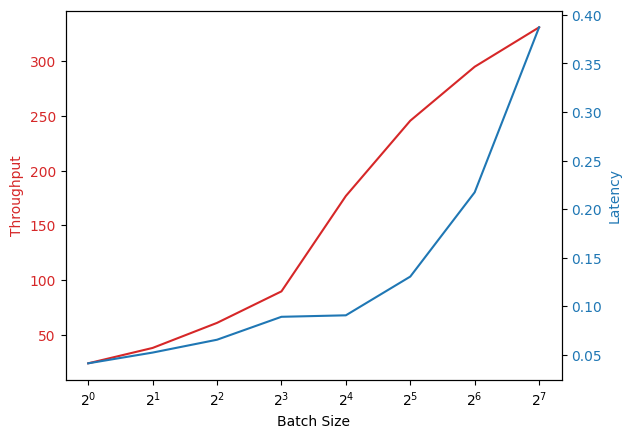

In [15]:
render_plot(
    batch_sizes,
    throughputs,
    latencies,
    "Batch Size",
    "Throughput",
    "Latency"
)